# Synthetic Sonic Log Generation -- Team UTFE 

* __Authors__: _Wen Pan_, _Honggeun Jo_, _Javier_, _Tianqi Deng_
* __Date__: May 1st, 2020


- <a>1. Introduction: Synthetic Sonic Curves Generation </a>
    - <a>1.1. Background</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Data Visualization, Preprocessing and Model Construction</a>
    - <a>4.1. Submission 1</a>
- <a>5. Summary</a>

<a></a>

## <a>1. Introduction: Synthetic Sonic Curves Generation</a>


### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2. Imports</a>

<a>Top</a>

In [1]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import median_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.signal import medfilt
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint
import keras
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## <a>3. Read Data</a>

<a>Top</a>

In [2]:
# Data loading
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

## <a>4. Data Visualization, Preprocessing and Model Construction</a>

<a>Top</a>

### <a>4.1. Submission 1</a>

Requirements:
Numpy 1.14.3; tensorflow 1.10.0; pandas 0.23.0; scipy 1.1.0; keras 2.2.4
GPU: GTX 1050Ti


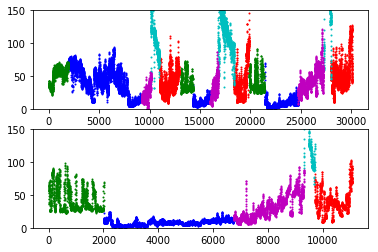

In [3]:
# Petrophysics-based zonation for both training and test set based on GR, ZDEN, CNC. Compared to test set,
# we found the training set showed similar spatial patterns, to take advantage of the spatial correlation
# we performed inter-well correlation. Per-zone estimation has been proved to be a good preprocessing method for well-log
# interpretation (Pan et al., in press; Pan et al., 2019)
df1['zone']=0
df1['zone'][13100:14297]=1;
df1['zone'][19890:21410]=1;
df1['zone'][:1925]=1;
#df1['zone'][1925:7000] no corresponding zone
#df1['zone'][7000:9210] DTS missing



df1['zone'][28022:]=2;
df1['zone'][18400:19888]=2;
df1['zone'][10993:12997]=2;

df1['zone'][27276:28022]=3;
df1['zone'][16823:18400]=3;
df1['zone'][10142:10993]=3;

df1['zone'][24753:27276]=4;
df1['zone'][16037:16823]=4;
df1['zone'][9210:10142]=4;

df2['zone']=0
df2['zone'][:2010]=1
df2['zone'][6749:9316]=4
df2['zone'][9316:9710]=3
df2['zone'][9710:]=2

co=['b','g','r','c','m','y']

# Figures show the patterns of gamma ray for different zones
for i in range(6):
    plt.subplot(2, 1, 1)
    plt.scatter(df1.index[df1.zone.values==i],df1.GR.values[df1.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])
    plt.subplot(2, 1, 2)
    plt.scatter(df2.index[df2.zone.values==i],df2.GR.values[df2.zone.values==i],s=1,color=co[i])
    plt.ylim([0,150])

In [4]:
# Delete points where data are missing 
df1=df1[['CNC','GR','ZDEN','HRD','DTC','DTS','zone','CAL','HRM','PE']]
df1.replace(['-999', -999], np.nan, inplace=True)
df1.dropna(axis=0, inplace=True)
df2=df2[['CNC','GR','ZDEN','HRD','zone','CAL','HRM','PE']]
df2.replace(['-999', -999], np.nan, inplace=True)
df2.dropna(axis=0, inplace=True)

DTC2=np.zeros(df2.shape[0])# array for saving predictions
DTS2=np.zeros(df2.shape[0])

We make the cross plots of different well logs, as expected, different zones show different correlations and spans of data.

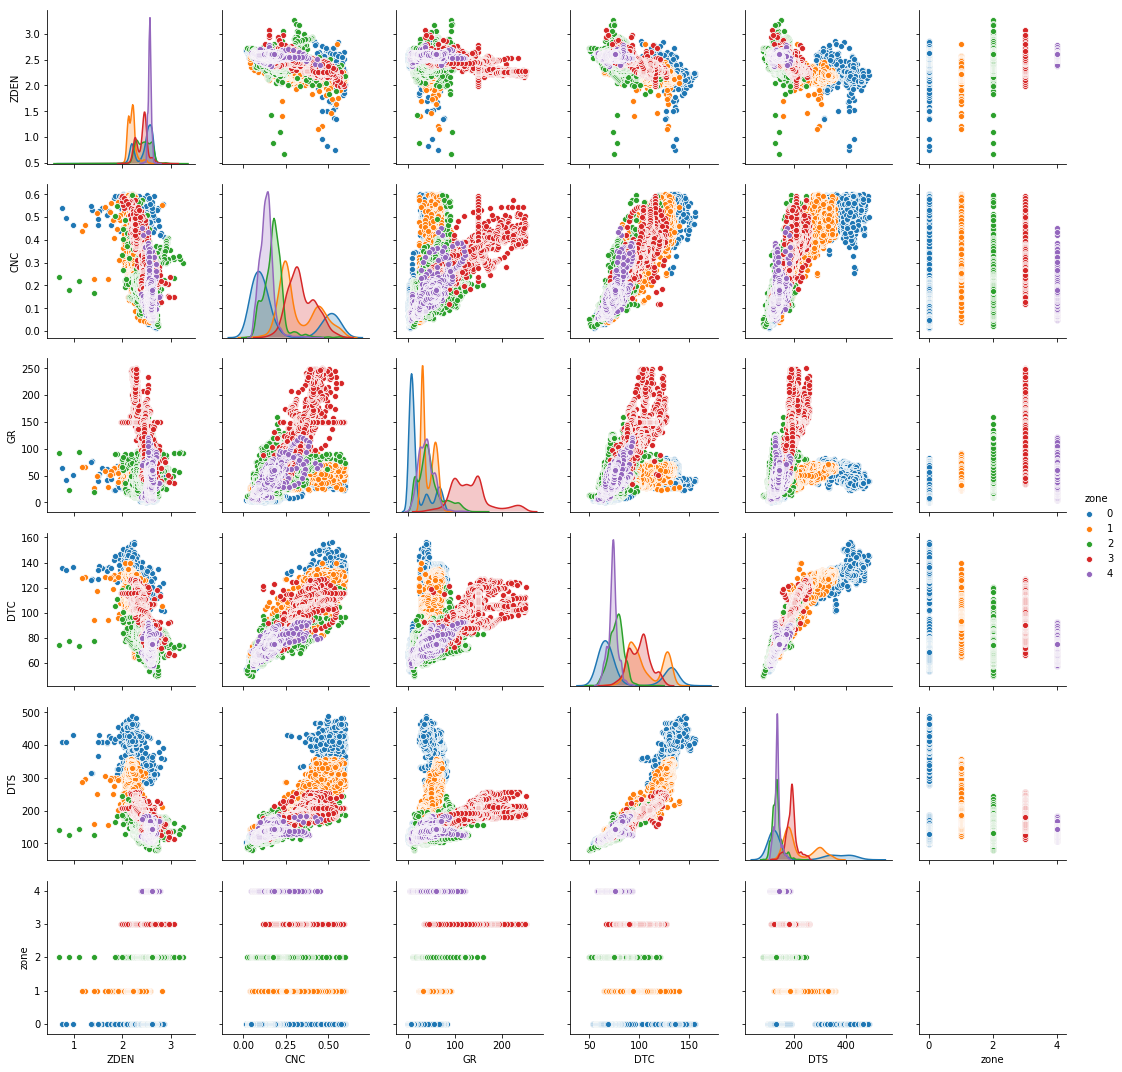

In [5]:
df_plot=df1.copy()
df_plot['CNC'][df_plot['CNC']>0.6]=np.nan
df_plot['CNC'][df_plot['CNC']<-0.15]=np.nan
df_plot['GR'][df_plot['GR']>250]=150
df_plot.dropna(axis=0, inplace=True)
g=sb.pairplot(df_plot[['ZDEN', 'CNC','GR','DTC','DTS','zone']],hue='zone')


In [6]:
# Preprocessing: 10000 data points in the test well should roughly correspond to 5000 ft, 
# which is too long for a well, thus we think it could be resampled. The artifacts in the cross plots (continuous dots)
# also indicate the existence of resampling.
# To alieviate the aliasing problem caused by resampling, and try to restore the true correlation,
# we calculate gradients to differentiate
# real data from interpolated data, and use medidan filter to capture the general trends of different well logs.

#Perform logrithmic transformation to resistivity logs to avoid large weight on resisitivity logs
df1['HRD_log']=np.log(df1.HRD.values)
df2['HRD_log']=np.log(df2.HRD.values)
df1['HRM_log']=np.log(df1.HRM.values)
df2['HRM_log']=np.log(df2.HRM.values)

# Calculate the gradients of input logs
# Interpolated well logs should have similar gradients
for i in df1.keys():
    df1[i+'grad']=np.gradient(df1[i].values)
for i in df2.keys():
    df2[i+'grad']=np.gradient(df2[i].values)
#Observe the patterns of logs



We Perform sonic logs estimation for each zone.
Caliper log is not used because there is no trong correlation between caliper log and sonic logs, sonic logs is sensitive to the density and porosity of the formation, thus the gradients of logs that measures the density and porosity of the formation are used as input features.

In [7]:
for iiii in [0,1,2,3,4]:
    df=df1[df1.zone.values==iiii].copy()
    df_test=df2[df2.zone.values==iiii].copy()


    x=df[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad']].copy()
    
    # To remove the noise, preserve the relative magnitude of the signals and given the fact that the vertical resolution of sonic logs are 
    #not as high as other logs, we use median filter to preprocessing the input features.
    for i in x.keys():
        x[i]=median_filter(df[i].values,21,mode='nearest')
    y=df[['DTC','DTS']].copy()
    
    # Minmax scaling is used to constrain the range of the output.
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_train = scaler_X.fit_transform(x.values)
    x_train=np.concatenate([x_train[1:-1],x_train[0:-2],x_train[2:]],axis=-1)    
    y_train = scaler_y.fit_transform(y.values)
    y_train = y_train[1:-1]
    
    #same operations are applied to test set.
    x_test=df_test[['CNC','GR','ZDEN','HRD_log','HRM_log','PE','CNCgrad','GRgrad','ZDENgrad']].values#,'RM_log'
    for i in range(x_test.shape[1]):
        x_test[:,i]=median_filter(x_test[:,i],21,mode='nearest')
    x_test=scaler_X.transform(x_test)
    # To account for spatial correlations, we add window to take into account the effects of logs at adjacent depths.
    # add window
    x_test=np.concatenate([x_test[1:-1],x_test[0:-2],x_test[2:]],axis=-1) 

    # A simple fully connected neural network is used for prediction
    model_1 = Sequential([
        Dense(24, activation='relu', input_shape=(27,)),
        Dense(12, activation='relu'),
        Dense(2,activation='sigmoid'),
    ])
 

    
    model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
    np.random.seed(1)
    set_random_seed(2)
    
    save_model_name = str(iiii)+'_Model'
    model_checkpoint = ModelCheckpoint(save_model_name,monitor='loss', mode = 'min', save_best_only=True, verbose=1)
    hist_1 = model_1.fit(x_train, y_train, batch_size=10, epochs=9, callbacks=[model_checkpoint])
    
    y_test2=model_1.predict(x_test)
    y_test2=scaler_y.inverse_transform(y_test2)
    y_test2=np.concatenate([y_test2[0:1,:],y_test2,y_test2[-1:,:]],axis=0)
    # save the prediction
    DTC2[df2.zone.values==iiii]=y_test2[:,0]
    DTS2[df2.zone.values==iiii]=y_test2[:,1]

Epoch 1/9
7285/7285 [==============================] - 4s 587us/step - loss: 0.0106 - mean_absolute_error: 0.0558

Epoch 00001: loss improved from inf to 0.01059, saving model to 0_Model
Epoch 2/9
7285/7285 [==============================] - 2s 252us/step - loss: 0.0012 - mean_absolute_error: 0.0221

Epoch 00002: loss improved from 0.01059 to 0.00116, saving model to 0_Model
Epoch 3/9
7285/7285 [==============================] - 2s 286us/step - loss: 9.7125e-04 - mean_absolute_error: 0.0201

Epoch 00003: loss improved from 0.00116 to 0.00097, saving model to 0_Model
Epoch 4/9
7285/7285 [==============================] - 2s 245us/step - loss: 8.8513e-04 - mean_absolute_error: 0.0191

Epoch 00004: loss improved from 0.00097 to 0.00089, saving model to 0_Model
Epoch 5/9
7285/7285 [==============================] - 2s 253us/step - loss: 8.2835e-04 - mean_absolute_error: 0.0184

Epoch 00005: loss improved from 0.00089 to 0.00083, saving model to 0_Model
Epoch 6/9
7285/7285 [================

Epoch 8/9
3307/3307 [==============================] - 1s 267us/step - loss: 0.0037 - mean_absolute_error: 0.0444

Epoch 00008: loss improved from 0.00371 to 0.00367, saving model to 4_Model
Epoch 9/9
3307/3307 [==============================] - 1s 285us/step - loss: 0.0037 - mean_absolute_error: 0.0442

Epoch 00009: loss improved from 0.00367 to 0.00365, saving model to 4_Model


Model Validation with given 20% real data:

In [8]:
# Find DTS and DTC of 20% real data:
df3 = pd.read_csv('real_result_20perc.csv')
dtc=-999*np.ones(len(df3))
dts=-999*np.ones(len(df3))
for i in range(2217):
    flag = (abs(df2['GR']-df3['GR'][i])<0.001) * \
    (abs(df2['ZDEN']-df3['ZDEN'][i])<0.001) * \
    (abs(df2['CNC']-df3['CNC'][i])<0.005) * \
    (abs(df2['PE']-df3['PE'][i])<0.001)
    dts[i] = DTS2[flag]
    dtc[i] = DTC2[flag]

RMSE of test data (#1 DTC): 4.77
RMSE of test data (#2 DTS): 17.28
Overall RMSE = 12.68


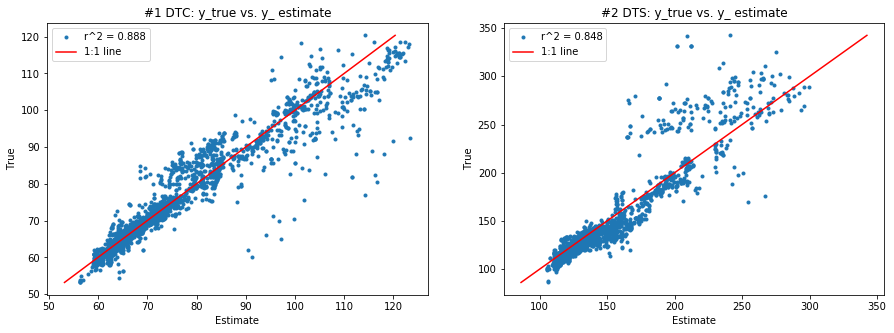

In [16]:
# Compute estimations:
y_20test_ = np.concatenate([dtc.reshape(dtc.shape[0],1), dts.reshape(dts.shape[0],1)], axis=1) 
y_20true_ = df3[['DTC','DTS']].values

# Plot results:
plt.figure(figsize=(15,5))
i = 0
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#1 DTC: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()
i += 1
plt.subplot(1,2,i+1)
plt.plot(y_20test_[:,i], y_20true_[:,i], '.', label = 'r^2 = %.3f' % (r2_score(y_20true_[:,i], y_20test_[:,i])))
plt.plot([y_20true_[:,i].min(),y_20true_[:,i].max()],[y_20true_[:,i].min(),y_20true_[:,i].max()], 'r', label = '1:1 line')
plt.title('#2 DTS: y_true vs. y_ estimate'); plt.xlabel('Estimate'); plt.ylabel('True')
plt.legend()

MSE_0 = mean_squared_error(y_20true_[:,0], y_20test_[:,0]);
RMSE_0 = np.sqrt(mean_squared_error(y_20true_[:,0], y_20test_[:,0]));
MSE_1 = mean_squared_error(y_20true_[:,1], y_20test_[:,1]);
RMSE_1 = np.sqrt(mean_squared_error(y_20true_[:,1], y_20test_[:,1]));
print('RMSE of test data (#1 DTC): %.2f' %(RMSE_0))
print('RMSE of test data (#2 DTS): %.2f' %(RMSE_1))
print('Overall RMSE = %.2f' %np.sqrt((MSE_0+MSE_1)/2))

Comparison between computation result and submission:

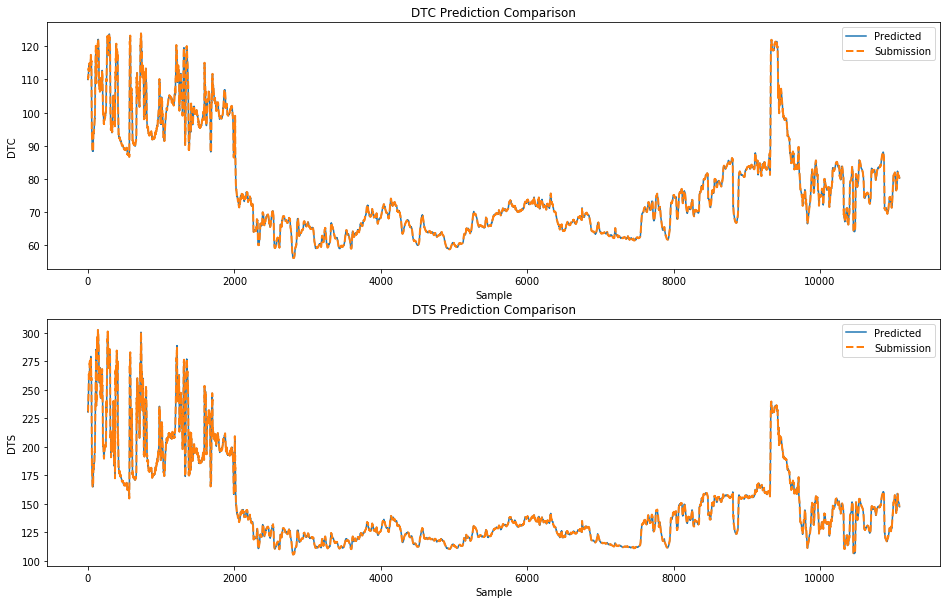

In [13]:
mysubmission=pd.read_csv('UTFE_submission_1.csv')
plt.subplots(nrows=1, ncols=2, figsize=(16,10))
plt.subplot(2, 1, 1)
plt.plot(DTC2)
plt.plot(mysubmission['DTC'].values,'--',linewidth=2)
plt.legend(['Predicted','Submission'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

plt.subplot(2, 1, 2)
plt.plot(DTS2)
plt.plot(mysubmission['DTS'].values,'--',linewidth=2)
plt.legend(['Predicted','Submission'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction Comparison')
plt.show()

In [14]:
output_result = pd.DataFrame({'DTC':DTC2, 'DTS':DTS2})
output_result.head()

,DTC,DTS
0,109.978676,230.498611
1,109.978676,230.498611
2,110.120193,230.707581
3,110.744263,232.782349
4,110.469650,233.401123


In [15]:
#output_result.to_csv(path_or_buf='./sample_submission.csv', index=False)
output_result.to_csv(path_or_buf='./UTFE_submission.csv', index=False)

## <a>5. Summary</a>

<a>Top</a>

o. We find the well-log data is redundent, pure deep neural network may not be able to learn the correlation among logs very well and may cause overfitting. Simple shallow neural networks with 2 layers yield good results.

o. Petrophysics- and signal-processing-based feature engineering helps machine learning models to learn better correlations between the input features and output logs. Expert knowledge from petrophysicists is essential for the successful application of machine-learning methods to well-log analysis.

o. Inter-Well correlations and different machine learning models for different zones improve the performance of our models. By incorporating spatial continuity, multi-well correlation helps machine-learning models to learn better correlations for each zone.

Reference:

Pan, W., Torres-Verdin, C., Pyrcz, M.J. and Duncan, I.J. (In press). Reducing the Uncertainty of Multi-Well Petrophysical Interpretation with New Data-Driven Methods

Pan, W., Torres-Verdin, C., Pyrcz, M.J. and Duncan, I.J. (2019). Interpretation of Well Logs Acquired in Multi-Well Hydrocarbon Fields via Generative Adversarial Networks (GAN). 2019 UT formation evaluation consortium.